# Soybean Image Classifier

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob


In [0]:
os.chdir('/content/drive/My Drive/Siraj/HW_7/dataset')

In [4]:
print(os.listdir())

['soil', 'soybean', 'broadleaf', 'grass']


**Data Preprocessing**

In [0]:
data_dir = r'/content/drive/My Drive/Siraj/HW_7/dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean']

# Number of files
num_file = 1100
# Store file names
all_files = []
# Amount of data
num_data = num_file * len(classes)
# Initialize all values with 0
Y = np.zeros(num_data)

# Get files
for i, cls in enumerate(classes):
  all_files += [f for f in glob.glob(data_dir + cls + '/*.tif')][:num_file]
  # Store class label in Y
  Y[i * num_file: (i + 1) * num_file] = i 

**Image processing**

In [0]:
# Define image dimension
image_width = 200
image_height = 200
image_channel = 3
dimension = image_width * image_height * image_channel

# Create nd array that will store images
X = np.ndarray(shape=(num_data, image_width, image_height, image_channel), dtype=np.uint8) 

# Add all images to X array
for i, file in enumerate(all_files):
  X[i] = cv2.resize(cv2.imread(file), (image_width, image_height)) 

In [0]:
def show_image(image):
  fig, ax = plt.subplots()
  im = ax.imshow(image)
  plt.show()
  print(image.shape) 

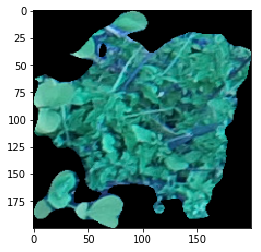

(200, 200, 3)


In [8]:
image = X[12]
show_image(image)

**Train, validation and test sets**

In [9]:
# Create empty arrays
X_train = np.empty(shape=(4000, image_width, image_height, image_channel), dtype=np.uint8)
X_val = np.empty(shape=(200, image_width, image_height, image_channel), dtype=np.uint8)
X_test = np.empty(shape=(200, image_width, image_height, image_channel), dtype=np.uint8)

Y_train = np.empty(4000)
Y_val = np.empty(200)
Y_test = np.empty(200)

# Set x and y values
for i, cls in enumerate(classes):
  X_test[50 * i: 50 * (i + 1)] = X[np.where(Y == i)[0][:50]]
  X_val[50 * i: 50 * (i + 1)] = X[np.where(Y == i)[0][50:100]]
  X_train[1000 * i: 1000 * (i + 1)] = X[np.where(Y == i)[0][100:]]

  Y_test[50 * i: 50 * (i + 1)] = i
  Y_val[50 * i: 50 * (i + 1)] = i
  Y_train[1000 * i: 1000 * (i + 1)] = i

# We can save memory by deleting X and Y
#del Y
#del X

# Select random x and y train data
train_indexes = np.random.permutation(X_train.shape[0]) # Create random indexes array with the length of X_train.shape[0]
Y_train = Y_train[train_indexes].astype(int) 
X_train = X_train[train_indexes]

# Reshape the train, test, val data
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

# Create custom tiny dataset for testing
X_tiny = X_train[100:110].astype('float64')
Y_tiny = Y_train[100:110].astype(int)
num_dev = 500

# Create custom dev dataset for testing
X_dev = X_train[0:num_dev].astype('float64')
Y_dev = Y_train[0:num_dev].astype(int)

# Compute the mean image
mean_image = np.mean(X_train, axis=0) # axis=0. stack horizontally
# Subtract the mean image from train and test data 
X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


In [0]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

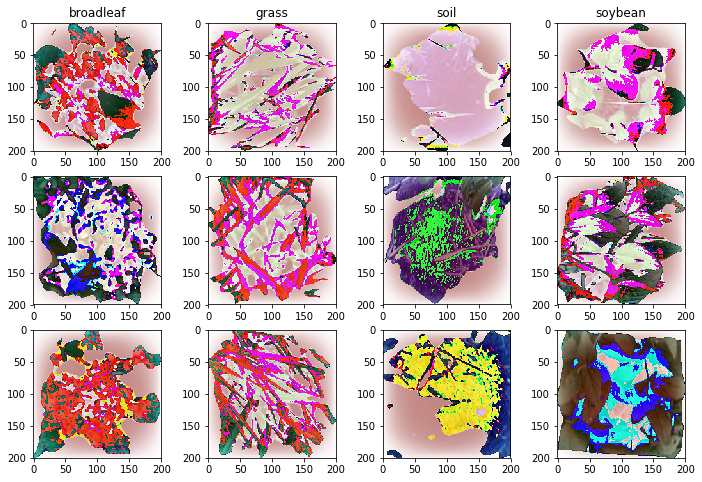

In [11]:
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 3

# Plot 3 images of each class
for Y, cls in enumerate(classes):
  indexes = np.flatnonzero(Y == Y_train)
  indexes = np.random.choice(indexes, samples_per_class, replace=False)
  for i, index, in enumerate(indexes):
    plt_index = i * n_class + Y + 1
    plt.subplot(samples_per_class, n_class, plt_index)
    plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))
    if i == 0: plt.title(cls)

plt.show()

In [0]:
class NeuralNetwork:
  hidden_size = 200
  input_size = image_width * image_height * image_channel
  output_size = n_class

  """
  w1: first layer weight
  w2: second layer weight
  """
  w1 = 1e-3 * np.random.randn(input_size, hidden_size)
  b1 = np.zeros(hidden_size)
  w2 = 1e-3 * np.random.randn(hidden_size, output_size)
  b2 = np.zeros(output_size)
    
  alpha = 1e-5
  batch_size = 100
    
  epochs = 500
  
  def train(self, X, Y, X_val, Y_val):
    N, D = X.shape
    N_val = X_val.shape[0]
    iteration_per_epoch = max(N / self.batch_size, 1)

    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    
    for it in range(self.epochs):
      sampling = np.random.choice(np.arange(N), self.batch_size, replace=False) # Create random array data

      # Getting batches for x and y
      X_batch = X[sampling]
      Y_batch = Y[sampling]

      loss, grads = self.loss(X_batch, Y=Y_batch)
      loss_hist.append(loss)

      # Make the model learning and reshape the parameters of the network
      self.w1 += -1.0 * self.alpha * grads['w1']
      self.b1 += -1.0 * self.alpha * grads['b1']
      self.w2 += -1.0 * self.alpha * grads['w2']
      self.b2 += -1.0 * self.alpha * grads['b2']

      if it % 10 == 0:
        print('iteration: %d / %d | Loss: %f' % (it, self.epochs, loss))
    
      if it % iteration_per_epoch == 0:
        train_acc = (self.predict(X_batch) == Y_batch).mean()
        val_acc = (self.predict(X_val) == Y_val).mean()
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        self.alpha *= 0.95
    
    return {
        'loss_hist': loss_hist,
        'train_acc_hist': train_acc_hist,
        'val_acc_hist': val_acc_hist
    }

  def relu(self, z):
    return np.maximum(0, z)
  
  def predict(self, X):
    Y_pred = None
    layer1 = self.relu(X.dot(self.w1) + self.b1)
    scores = layer1.dot(self.w2) + self.b2
    Y_pred = np.argmax(scores, axis=1)
    return Y_pred

  def loss(self, X, Y = None):
    N, D = X.shape

    # Calculate the loss of our layer1
    layer1 = self.relu(X.dot(self.w1) + self.b1)
    scores = layer1.dot(self.w2) + self.b2

    if (Y is None):
      return scores

    # Calculate the actual loss
    scores -= scores.max()
    scores = np.exp(scores)
    scores_sumexp = np.sum(scores, axis=1)
    softmax = scores / scores_sumexp.reshape(N, 1)
    loss = -1.0 * np.sum(np.log(softmax[range(N), Y]))
    loss /= N

    grads = {}
    correct_class_scores = scores[range(N), Y]
    softmax[range(N), Y] = -1.0 * (scores_sumexp - correct_class_scores) / scores_sumexp
    softmax /= N

    grads['w2'] = layer1.T.dot(softmax)
    grads['b2'] = np.sum(softmax, axis=0)

    hidden = softmax.dot(self.w2.T)

    grads['w1'] = X.T.dot(hidden)
    grads['b1'] = np.sum(hidden, axis=0)

    return loss, grads

In [13]:
nn = NeuralNetwork()
stats = nn.train(X_dev, Y_dev, X_val, Y_val)

iteration: 0 / 500 | Loss: 1.405231
iteration: 10 / 500 | Loss: 1.355908
iteration: 20 / 500 | Loss: 1.292501
iteration: 30 / 500 | Loss: 1.221964
iteration: 40 / 500 | Loss: 1.202144
iteration: 50 / 500 | Loss: 1.189387
iteration: 60 / 500 | Loss: 1.137790
iteration: 70 / 500 | Loss: 1.116371
iteration: 80 / 500 | Loss: 1.097756
iteration: 90 / 500 | Loss: 1.073585
iteration: 100 / 500 | Loss: 1.002264
iteration: 110 / 500 | Loss: 1.034396
iteration: 120 / 500 | Loss: 1.021046
iteration: 130 / 500 | Loss: 1.032206
iteration: 140 / 500 | Loss: 0.968867
iteration: 150 / 500 | Loss: 1.038190
iteration: 160 / 500 | Loss: 0.978811
iteration: 170 / 500 | Loss: 0.971371
iteration: 180 / 500 | Loss: 0.962308
iteration: 190 / 500 | Loss: 0.969836
iteration: 200 / 500 | Loss: 0.968037
iteration: 210 / 500 | Loss: 0.973998
iteration: 220 / 500 | Loss: 0.982549
iteration: 230 / 500 | Loss: 0.969608
iteration: 240 / 500 | Loss: 0.966661
iteration: 250 / 500 | Loss: 0.910169
iteration: 260 / 500 | 

In [14]:
print((nn.predict(X_test) == Y_test).mean())

0.615


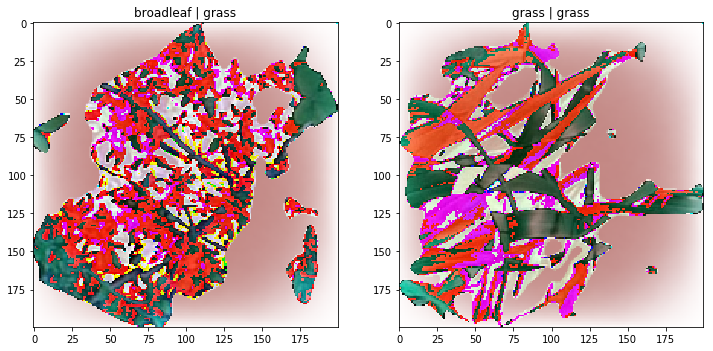

In [15]:
index = np.flatnonzero(0 == Y_train)
index = np.random.choice(index, 1, replace=False)
prediction = nn.predict(X_train[index])

plt.subplot(1, 2, 1)
plt.title('{} | {}'.format(classes[0], classes[prediction[0]]))
plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))

index = np.flatnonzero(1 == Y_train)
index = np.random.choice(index, 1, replace=False)
prediction = nn.predict(X_train[index])

plt.subplot(1, 2, 2)
plt.title('{} | {}'.format(classes[1], classes[prediction[0]]))
plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))